# HomeWork 9

**DeadLine : 23:59 5 Azar 1399**

**Total points : 100 pts**

Import some prerequisites.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Run this cell for plotting.

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# PART 2

Here is for your helper functions (optional).

Implement this function for Augmented reality.

In [3]:
def AR(background, image):
    '''
    Adds the input image to the background image properly.
    
    Parameters:
        background (numpy.ndarray) : background image
        image (numpy.ndarray): input image
    
    Returns:
        numpy.ndarray: The result image.
    '''
    print(background.shape)
    print(image.shape)
    result = background.copy()
    h,w,d = image.shape
    print(h,w,d)
    src = np.array([np.array([0, 0]),
                  np.array([ 0,h-1]),
                  np.array([ w-1,h-1,]),
                  np.array([w-1,0])],dtype='float32')
    
    with open("back.csv") as csv_file:
        import csv
        csv_reader = csv.reader(csv_file, delimiter=",")
        dst = []
        for i, row in enumerate(csv_reader):
            try:
                dst.append(np.array([row[1], row[2]]))
            except ValueError:
                continue
    dst = np.array(dst, dtype='float32')
    
    print(src)
    print(dst)
    M, _ = cv2.findHomography(src, dst)
    M = M[:2,:]
    print(M.shape)
    transformed_image = cv2.warpAffine(image,M,(result.shape[1], result.shape[0]))
    
    for i in range(transformed_image.shape[0]):
        for j in range(transformed_image.shape[1]):
            if transformed_image[i][j].all() == 0:
                continue
            else:
                result[i][j] = transformed_image[i][j]
    
    return result

Test your implementation (dont change this cell)

(512, 351, 3)
(1800, 1200, 3)
1800 1200 3
[[   0.    0.]
 [   0. 1799.]
 [1199. 1799.]
 [1199.    0.]]
[[147. 105.]
 [147. 222.]
 [233. 222.]
 [233. 105.]]
(2, 3)


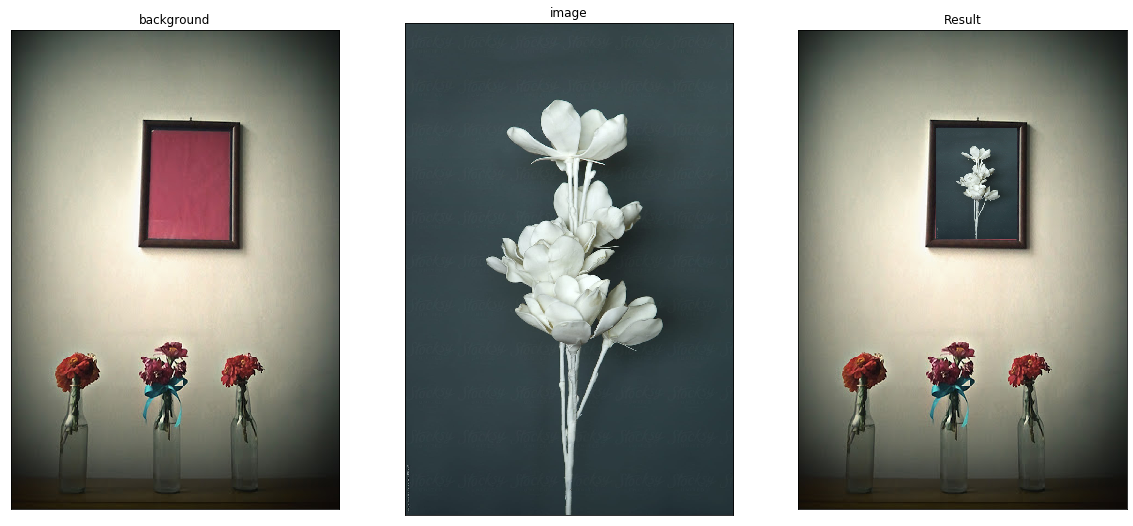

In [4]:
image_list = []

background = cv2.imread(os.path.join('images', 'background.jpg'))
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
image_list.append([background, 'background', 'img'])

image = cv2.imread(os.path.join('images', '1.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_list.append([image, 'image', 'img'])

image_list.append([AR(background, image), 'Result', 'img'])


plotter(image_list,1 , 3, True, 20, 10, '2')

# PART 3A

Here is for your helper functions (optional).

Implement this function to get the global otsu algorithm output.

In [5]:
def global_otsu(image):
    '''
    Applys global otsu on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result panorama image.
    '''
    
    out_img = image.copy()
    
    #Write your code here
    total_pixels = out_img.shape[0] * out_img.shape[1]
    mean_weigth = 1.0/total_pixels
    hist, bins = np.histogram(out_img, np.array(range(0, 256)))
    final_thresh = -1
    final_value = float('inf')
    for thresh in bins[1:-1]:
        Wb = np.sum(hist[:thresh]) / total_pixels
        Wf = np.sum(hist[thresh:]) / total_pixels
        
        mub = np.var(hist[:thresh])
        muf = np.var(hist[thresh:])
        value = Wb * (mub ** 1) + Wf * (muf ** 1)

        if value < final_value:
            final_thresh = thresh
            final_value = value

    out_img[out_img > final_thresh] = 255
    out_img[out_img < final_thresh] = 0
    
    return out_img

Test your implementation (dont change this cell)

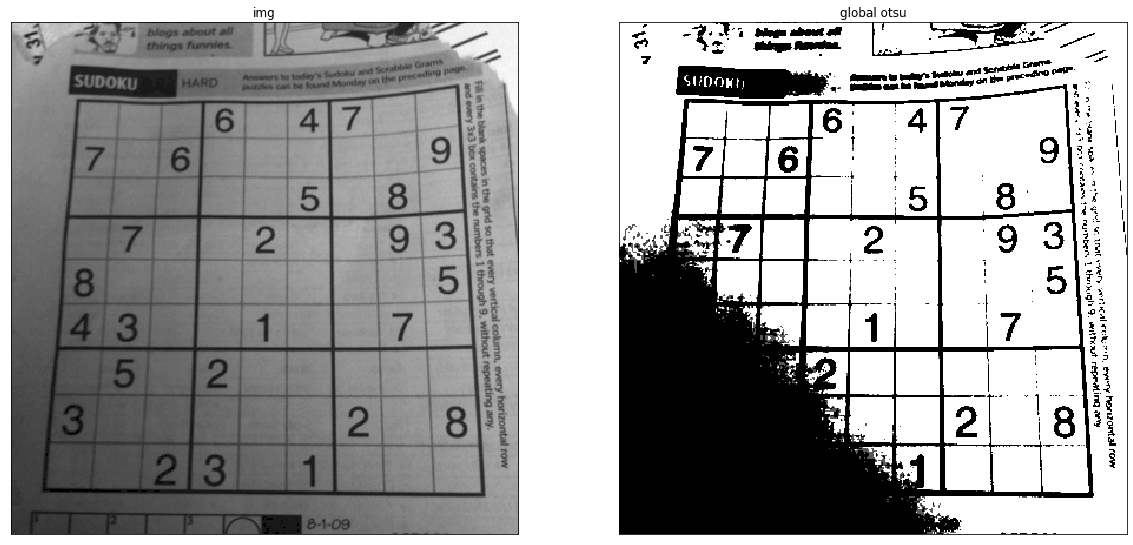

In [6]:
image_list = []

image = cv2.imread(os.path.join('images', 'q2.png'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'img', 'img'])



image_list.append([global_otsu(image), 'global otsu', 'img'])

plotter(image_list, 1, 2, True, 20, 10, '3A')

# PART 3B

Here is for your helper functions (optional).

Implement this function to get local otsu algorithm output.

In [7]:
def local_otsu(image):
    '''
    Applys local otsu on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result panorama image.
    '''
    
    h, w = image.shape
    out_img = image.copy()
    top_left = image[:h//2,:w//2]
    bottom_left = image[h//2:,:w//2]
    top_right = image[:h//2,w//2:]
    bottom_right = image[h//2:,w//2:]
    
    top_left = global_otsu(image[:h//2,:w//2])
    bottom_left = global_otsu(image[h//2:,:w//2])
    top_right = global_otsu(image[:h//2,w//2:])
    bottom_right = global_otsu(image[h//2:,w//2:])
    image = np.concatenate([np.concatenate([top_left,top_right],axis=-1), 
                            np.concatenate([bottom_left, bottom_right],axis=-1)])
    return image

Test your implementation (dont change this cell)

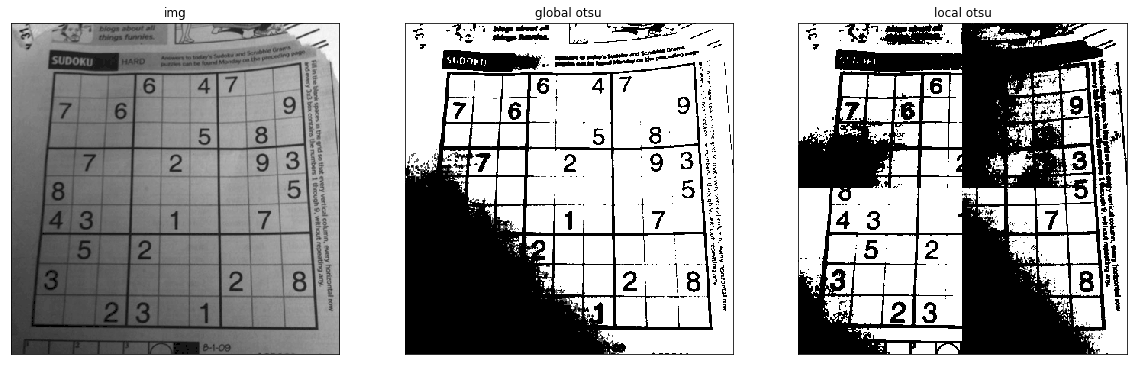

In [8]:
image_list = []

image = cv2.imread(os.path.join('images', 'q2.png'),cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'img', 'img'])


image_list.append([global_otsu(image), 'global otsu', 'img'])
image_list.append([local_otsu(image), 'local otsu', 'img'])

plotter(image_list, 1, 3, True, 20, 10, '3B')

# PART 3C

Here is for your helper functions (optional).

Implement this function to get the adaptive threshold algorithm output.

In [9]:
def adaptive_th(image):
    '''
    Applys adaptive threshold on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result panorama image.
    '''
    
    out_img = image.copy()
    
    #Write your code here
    out_img = cv2.adaptiveThreshold(src=out_img,
                                    maxValue=255,
                                    adaptiveMethod=1,
                                    thresholdType=cv2.THRESH_BINARY,
                                    blockSize=75,
                                    C=5)
    
    return out_img

Test your implementation (dont change this cell)

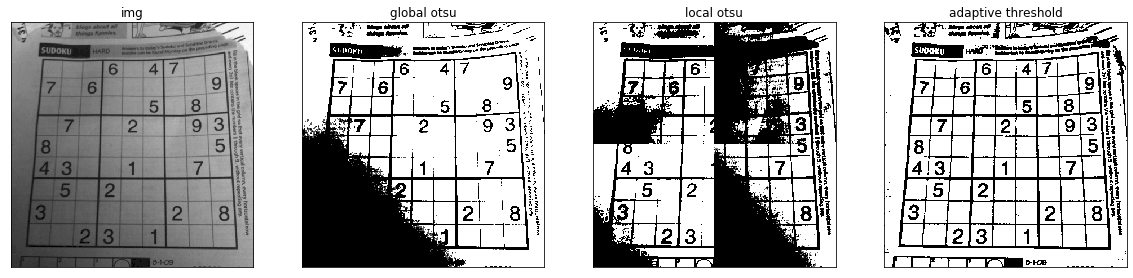

In [10]:
image_list = []

image = cv2.imread(os.path.join('images', 'q2.png'),cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'img', 'img'])


image_list.append([global_otsu(image), 'global otsu', 'img'])
image_list.append([local_otsu(image), 'local otsu', 'img'])
image_list.append([adaptive_th(image), 'adaptive threshold', 'img'])

plotter(image_list, 1, 4, True, 20, 10, '3C')

# PART 4

Here is for your helper functions (optional).

In [11]:
def correlation_coefficient(patch1, patch2):
    return cv2.matchTemplate(patch1,patch1,cv2.TM_CCORR_NORMED)

def euclidean_distance(point1, point2):
    x1,y1 = point1
    x2,y2 = point2
    return np.sqrt(np.square(x1-x2) + np.square(y1-y2))

Implement matching here.

In [16]:
def find_match(image1, image2):
    '''
    Finds match points between two input images.
    
    Parameters:
        image1 (numpy.ndarray): input image.
        image2 (numpy.ndarray): second input image.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    image1_cop = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_cop = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    image1_cop = np.float32(image1_cop)
    image2_cop = np.float32(image2_cop)
    t = 250
    
    harris1 = cv2.cornerHarris(image1_cop,2,5,k=0.07)
    harris2 = cv2.cornerHarris(image2_cop,2,5,k=0.07)
    dest1 = cv2.dilate(harris1, None) 
    dest2 = cv2.dilate(harris2, None) 
    keypoints1 = dest1 > 0.02 * dest1.max()
    keypoints2 = dest2 > 0.02 * dest2.max()
    img1 = image1.copy()
    img2 = image2.copy()

    window_size = 9
    r = window_size//2
    
    k1 = np.argwhere(keypoints1)
    k2 = np.argwhere(keypoints2)
    euc_thresh = 3
    
    print(k1.shape, k2.shape)
    
    for i in range(len(k1)-1):
        for j in range(i+1,len(k1)):
            if euclidean_distance(k1[i],k1[j]) < euc_thresh:
                x,y = k1[j]
                keypoints1[x][y] = False
                
    for i in range(len(k2)-1):
        for j in range(i+1,len(k2)):
            if euclidean_distance(k2[i],k2[j]) < euc_thresh:
                x,y = k2[j]
                keypoints2[x][y] = False
                
    for i in range(len(k1)):
        h ,w = keypoints1.shape
        x ,y = k1[i]
        if x - r < 0 or x + r >= h or y - r < 0 or y + r >= w:
            keypoints1[x][y] = False
            
    for i in range(len(k2)):
        h ,w = keypoints2.shape
        x ,y = k2[i]
        if x - r < 0 or x + r >= h or y - r < 0 or y + r >= w:
            keypoints2[x][y] = False
            
    k1 = np.argwhere(keypoints1)
    k2 = np.argwhere(keypoints2)
    
    img1[keypoints1] = [255,0,0]
    img2[keypoints2] = [255,0,0]
    
    result = np.concatenate([img1,img2],axis=-2)
    
    print(k1.shape, k2.shape)
    
    for x1,y1 in k1:
        best_match = None
        best_idx = None
        best_value = float('-inf')
        for idx,(x2,y2) in enumerate(k2):
            corr = correlation_coefficient(image1[x1-r:x1+r+1,y1-r:y1+r+1],
                                                image2[x2-r:x2+r+1,y2-r:y2+r+1])
            if corr > best_value:
                best_value = corr
                best_idx = idx
                best_match = (y2 + keypoints2.shape[1],x2)
        if best_idx is None:
            continue
        k2 = np.delete(k2,(best_idx),axis=0)
        cv2.line(result, (y1,x1), best_match, (np.random.randint(0,256),
                                               np.random.randint(0,256),
                                               np.random.randint(0,256)), 2) 

    return result

Test your implementation (dont change this cell)

(3294, 2) (5273, 2)
(197, 2) (279, 2)


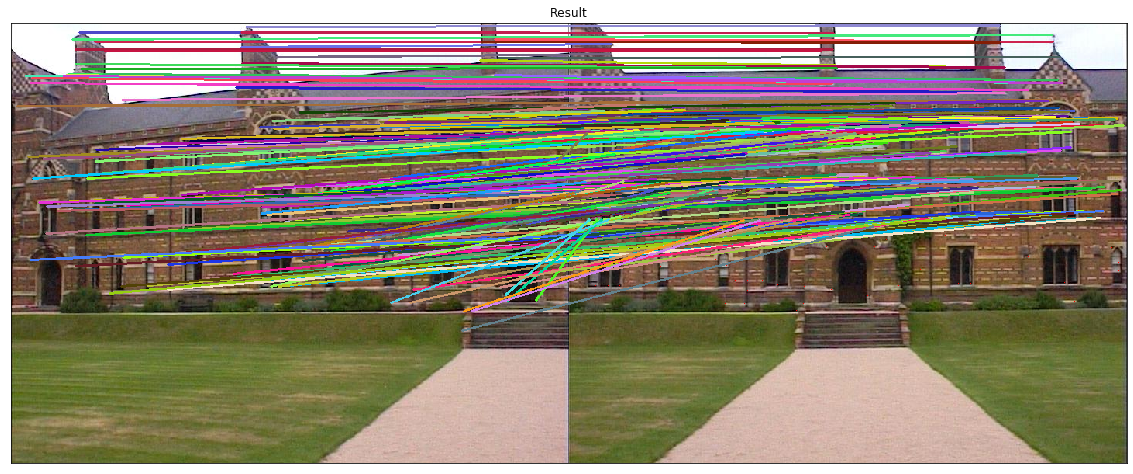

In [17]:
image_list = []

image1 = cv2.imread(os.path.join('images', 'building1.jpg'))
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread(os.path.join('images', 'building2.jpg'))
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image_list.append([find_match(image1,image2), 'Result', 'img'])

plotter(image_list,1 , 1, True, 20, 10, '4')

for create proper files for sending in quera run this cell.

In [14]:
!python notebook_converter.py

In [15]:
pic = np.array([3,4,5,5,6,12,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,15,15])
hist, bins = np.histogram(pic,np.array(range(0, 16)))
total_pixels = len(pic)
final_thresh = -1
final_value = float('inf')
for thresh in bins[1:-1]:
    Wb = np.sum(hist[:thresh]) / total_pixels
    Wf = np.sum(hist[thresh:]) / total_pixels

    mub = np.var(hist[:thresh])
    muf = np.var(hist[thresh:])
    value = Wb * (mub ** 1) + Wf * (muf ** 1)
    print(thresh)
    print(value)
    if value < final_value:
        final_thresh = thresh
        final_value = value
print(final_thresh)
print(final_value)

1
8.229591836734695
2
8.639053254437869
3
9.07638888888889
4
9.39945652173913
5
9.781304347826087
6
9.907675791733766
7
10.427129547471164
8
11.253479924578528
9
12.101986044015032
10
12.807391304347828
11
12.810815666546892
12
10.002113526570048
13
0.28974787754051967
14
3.3972937000887313
13
0.28974787754051967


End!!!